In [1]:
import cifar_gpu_fun
reload(cifar_gpu_fun)
from cifar_gpu_fun import *
from sklearn.neighbors import KNeighborsClassifier
import gc
from numba import jit
%pylab inline

Using gpu device 0: Tesla K20c (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)
/data/vaishaal/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


#### Define Some Constants 

In [299]:
NUM_FEATURE_BATCHES=1
DATA_BATCH_SIZE=(1280)
FEATURE_BATCH_SIZE=(1024)
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_CLASSES = 10
POOL_TYPE ='avg'
FILTER_GEN ='gaussian'
BANDWIDTH = 1.0
LAMBDAS = [1e-1/FEATURE_BATCH_SIZE, 1e-2/FEATURE_BATCH_SIZE, 1e-3/FEATURE_BATCH_SIZE, 1e-4/FEATURE_BATCH_SIZE, 1e-5/FEATURE_BATCH_SIZE]
CUDA_CONVNET = True
SCALE = 55.0
BIAS = 1.25
MIN_VAR_TOL = 1e-4
TOT_FEAT = FEATURE_BATCH_SIZE*NUM_FEATURE_BATCHES

In [6]:
def make_skip_empirical_filter_gen(patches, labels, channels=3, skip_min=0, skip_max=4, MIN_VAR_TOL=0):
    patches = patches.reshape(patches.shape[0]*patches.shape[1],*patches.shape[2:])
    all_idxs = np.random.choice(patches.shape[0], patches.shape[0], replace=False)
    curr_idx = [0]
    def skip_empirical_filter_gen(num_filters):
        idxs = all_idxs[curr_idx[0]:curr_idx[0]+num_filters]
        curr_idx[0] += num_filters
        unfiltered = patches[idxs].astype('float32').transpose(0,3,1,2)
        old_shape = unfiltered.shape
        unfiltered = unfiltered.reshape(unfiltered.shape[0], -1)
        unfiltered_vars = np.var(unfiltered, axis=1)
        filtered = unfiltered[np.where(unfiltered_vars > MIN_VAR_TOL)]
        out = filtered[:num_filters].reshape(num_filters, *old_shape[1:])
        total_skipped = 0
        for i in range(num_filters):
            # first calculate how many you are going to skip
            s = np.random.randint(skip_min, skip_max+1)            
            total_skipped += s*out[i].shape[0]
            # then pick indices to set to 0
            skip_idxs = np.random.choice(out[i].shape[1]**2, s, replace=False)
            out[i].reshape(out[i].shape[0],-1)[:, skip_idxs] = 0
        print "total skipped ", total_skipped
        return out
    return skip_empirical_filter_gen


In [300]:
np.random.seed(10)                                                                                                                                                                   
(XTrain, labelsTrain), (XTest, labelsTest) = load_cifar_processed()
if FILTER_GEN == 'gaussian':
    filter_gen = make_gaussian_filter_gen(1.0/v)
elif FILTER_GEN == 'empirical':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_empirical_filter_gen(patches, labelsTrain, MIN_VAR_TOL)
elif FILTER_GEN == 'empirical_balanced':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_balanced_empirical_filter_gen(patches, labelsTrain)
elif FILTER_GEN == 'gaussian_cov':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_gaussian_cov_filter_gen(patches)
elif FILTER_GEN == 'gaussian_cc_cov':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_gaussian_cc_cov_filter_gen(patches, labelsTrain)
elif FILTER_GEN == 'empirical_skip':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_skip_empirical_filter_gen(patches, labelsTrain)
else:
    raise Exception('Unknown FILTER_GEN value')

In [8]:
filter_gen = make_skip_empirical_filter_gen(patches, labelsTrain, skip_min=0, skip_max=0)

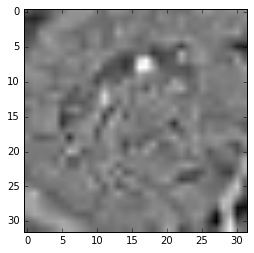

In [6]:
imshow(XTrain[0].transpose(1,2,0)[:,:,0], cmap=plt.cm.gray)

In [7]:
X.shape

NameError: name 'X' is not defined

In [ ]:
X = np.vstack((XTrain, XTest))
(Xlevel1, filters) = conv(X, filter_gen, 1024, 1, 1280, CUDA_CONVNET, pool_size=14, symmetric_relu=True)

Out Shape  2 x 2 x 2048
(1024, 3, 6, 6)
FEATURE BATCH # 0 DATA BATCH # 0  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 1  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 2  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 3  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 4  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 5  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 6  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 7  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 8  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 9  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 10  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 11  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 12  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 13  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 14  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 15  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 16  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 17  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 18  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 19  SIZE

In [ ]:
# Base line no dropout 40k filters
filter_gen = make_skip_empirical_filter_gen(patches, labelsTrain, skip_min=0, skip_max=0)
featurizeTrainAndEvaluateDualModelAsync(XTrain, XTest, labelsTrain, labelsTest, filter_gen, 10, regs=LAMBDAS)

RELOADING MOTHER FUCKER 3
CHILD Process Spun yupyup
Convolving features
Out Shape  2 x 2 x 2048
total skipped  0
FEATURE BATCH # 0 DATA BATCH # 0  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 1  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 2  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 3  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 4  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 5  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 6  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 7  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 8  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 9  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 10  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 11  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 12  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 13  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 14  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 15  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 16  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 17  SIZE IS  1280
FEATURE BATCH #

In [ ]:
# dropout small (max 0.25) little 40k filters
filter_gen = make_skip_empirical_filter_gen(patches, labelsTrain, skip_min=0, skip_max=9)
featurizeTrainAndEvaluateDualModelAsync(XTrain, XTest, labelsTrain, labelsTest, filter_gen, 10, regs=LAMBDAS)

RELOADING MOTHER FUCKER 3
Convolving features
Out Shape  2 x 2 x 2048
CHILD Process Spun yupyup
total skipped  14001
FEATURE BATCH # 0 DATA BATCH # 0  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 1  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 2  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 3  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 4  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 5  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 6  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 7  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 8  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 9  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 10  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 11  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 12  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 13  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 14  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 15  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 16  SIZE IS  1280
FEATURE BATCH # 0 DATA BATCH # 17  SIZE IS  1280
FEATURE BAT

In [63]:
XFinal = Xlevel1
XFinalTrain = XFinal[:50000,:,:,:].reshape(NUM_TRAIN,-1)
XFinalTest = XFinal[50000:,:,:,:].reshape(NUM_TEST,-1)
print "Output train data shape ", XFinalTrain.shape
print "Output test data shape ", XFinalTest.shape
print "Output filters shape ", filters.shape
convTrainAcc, convTestAcc = trainAndEvaluatePrimalModel(XFinalTrain, XFinalTest, labelsTrain, labelsTest, reg=100)
print "(conv) train: ", convTrainAcc, "(conv) test: ", convTestAcc

Output train data shape  (50000, 32768)
Output test data shape  (10000, 32768)
Output filters shape  (12, 6, 6, 1024)
X SHAPE  (50000, 32768)
Computing XTX
Done Computing XTX
REG is 100
Learning Primal Model
CONFUSION MATRIX
[[828  12  29  16   9   7   5   9  57  28]
 [  6 905   5   4   2   5   6   4  18  45]
 [ 56   9 687  42  57  44  64  28   7   6]
 [ 27  14  44 607  38 152  52  24  18  24]
 [ 10   2  33  42 756  19  64  59   8   7]
 [ 11   5  36 127  35 713  24  32  12   5]
 [  3   6  31  30  35  12 869   6   6   2]
 [ 15   5  19  27  38  52  11 815   6  12]
 [ 38  18   4   7   4   4   7   3 892  23]
 [ 21  51   6   4   7   2   8   7  23 871]]
(conv) train:  0.95004 (conv) test:  0.7943


In [47]:
random.choice(5)

3

In [49]:
print filters.shape

(3, 6, 6, 1024)


In [50]:
filters[0].shape[0]

6

In [74]:
np.random.choice(np.indices((5,5)), 5)

ValueError: a must be 1-dimensional

In [73]:
np.indices((5,5))

array([[[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]],

       [[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]])

In [83]:
filters[0].reshape(-1,1024)

array([[ -1.70444816e-01,  -3.03272426e-01,   1.37171626e+00, ...,
          2.57786006e-01,   1.57815561e-01,  -7.87950829e-02],
       [ -2.30296880e-01,   1.00283340e-01,   8.26390460e-04, ...,
          6.49847388e-01,   2.98254907e-01,  -5.19101731e-02],
       [ -1.28035054e-01,  -5.01830280e-01,  -3.27049404e-01, ...,
         -2.60016918e-01,  -2.30987780e-02,   2.18990356e-01],
       ..., 
       [  1.08705595e-01,   3.59030426e-01,  -2.79859453e-01, ...,
         -5.16299069e-01,  -1.59351379e-01,   1.81258261e-01],
       [ -2.88475901e-02,  -6.36781305e-02,  -3.80711228e-01, ...,
         -1.62647545e-01,  -6.82331622e-02,  -4.47625145e-02],
       [  8.55591744e-02,   3.60014886e-01,   4.05569851e-01, ...,
          1.30979732e-01,   2.63492167e-01,   1.32874295e-01]], dtype=float32)

In [92]:
filters[2].reshape(-1,1024)[4].shape

(1024,)

In [97]:
filters[2][0,3]

array([-0.19360606,  0.0720751 ,  0.86537236, ..., -0.28129727,
       -0.35387492,  0.00216588], dtype=float32)

In [17]:
1024 * 6 * 6 * 3

110592

In [54]:
np.sum(filters == 0)/float(1024*6*6*3)

0.24698893229166666

In [53]:
filters

array([[[[  2.84768231e-02,   0.00000000e+00,  -8.43683630e-02, ...,
            0.00000000e+00,   0.00000000e+00,   1.89050585e-02],
         [ -6.45961344e-01,   5.97532749e-01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,  -4.08615619e-02],
         [  0.00000000e+00,   0.00000000e+00,  -1.11592785e-01, ...,
           -1.87280342e-01,   0.00000000e+00,   0.00000000e+00],
         [  1.61094427e-01,  -3.57057154e-01,   1.64380819e-02, ...,
           -1.55086964e-02,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,  -2.11659282e-01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [ -1.10665016e-01,  -5.48072755e-01,   7.75905848e-02, ...,
           -8.37250650e-02,   0.00000000e+00,  -4.54986989e-02]],

        [[  3.52274895e-01,   0.00000000e+00,  -5.16699553e-02, ...,
            0.00000000e+00,  -5.00086546e-01,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+

In [17]:
XFinal = Xlevel1
XFinalTrain = XFinal[:50000,:,:,:].reshape(NUM_TRAIN,-1)
XFinalTest = XFinal[50000:,:,:,:].reshape(NUM_TEST,-1)

In [310]:
trainAndEvaluatePrimalModel(XFinalTrain, XFinalTest, labelsTrain, labelsTest, reg=100)

X SHAPE  (50000, 8192)
Computing XTX
Done Computing XTX
REG is 100
Learning Primal Model
CONFUSION MATRIX
[[751  37  38  13  11   5  12  14  88  31]
 [ 21 821  13  10   6   8  14   4  31  72]
 [ 63  19 540  50  74  70  92  53  24  15]
 [ 28  31  58 500  54 170  71  31  19  38]
 [ 34   8  44  50 606  33  93  92  21  19]
 [ 15   6  46 133  37 648  43  43  13  16]
 [ 13  15  39  39  28  18 831   6   7   4]
 [ 10  13  31  39  47  72  17 730  12  29]
 [ 48  43  12  12   3   9   6   3 828  36]
 [ 32  86   7  10   8   7  12   8  36 794]]


(0.81813999999999998, 0.70489999999999997)

In [ ]:
nearest_neighbors(XFinalTrain, XFinalTest, labelsTrain, labelsTest)

In [302]:
XFinal = Xlevel1
XFinalTrain = XFinal[:50000,:,:,:].reshape(NUM_TRAIN,-1)
XFinalTest = XFinal[50000:,:,:,:].reshape(NUM_TEST,-1)

In [306]:
v = np.var(XFinalTrain)

In [307]:
np.var(XFinalTrain/np.sqrt(v))

1.0000005

In [ ]:
predTrain = neigh.predict(XFinalTrain)

In [ ]:
predTest = neigh.predict(XFinalTest)

In [16]:
XFinal

In [ ]:
a = 4

In [14]:
def nearest_neighbor_mt(XTrain, XTest, YTrain):
        length = XTrain.shape[0]
        args = (result,) + args        
        chunklen = (length + 1) // numthreads
        distances = np.zeros(numthreads, 2)
        train_pieces = [XTrain[i * chunklen:(i + 1) * chunklen] for i in range(numthreads)] 
        # You should make sure inner_func is compiled at this point, because
        # the compilation must happen on the main thread. This is the case
        # in this example because we use jit().
        threads = [threading.Thread(target=nearest_test_pt, args=(results[i], train_pieces))
                 for (i,chunk) in enumerate(chunks)]
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
        np.argmin(results)
        return result
 
def nearest_test_pt(distances, train_chunk, XTest):
    threadstate = savethread()
    test_sq = np.dot(test, test)
    for j in range(XTest.shape[0]):
        test = XTest[j]
        test_sq = np.dot(test, test)
        for i in range(len(distances)):
            distances[j,i] = np.dot(train[i],train[i]) - np.dot(train[i], test) + test_sq 
    restorethread(threadstate)

In [16]:
XTrain

array([[[[ -5.10418832e-01,  -1.01881993e+00,  -9.80770111e-01, ...,
            4.35284883e-01,   3.80423725e-01,   3.36174905e-01],
         [ -1.54031408e+00,  -1.76911223e+00,  -1.38737571e+00, ...,
           -2.19702348e-02,   5.17911911e-02,   3.91262650e-01],
         [ -1.03158832e+00,  -1.17598438e+00,  -4.64248747e-01, ...,
           -1.01428725e-01,   3.60241950e-01,   1.24517724e-01],
         ..., 
         [  5.42089581e-01,   9.48075712e-01,   8.21981907e-01, ...,
            1.09862840e+00,  -1.94312882e+00,  -1.17045438e+00],
         [ -3.03322822e-01,  -2.62524784e-02,   4.93870586e-01, ...,
            2.04208612e+00,  -8.28551054e-01,  -5.97108960e-01],
         [ -5.56365848e-01,  -6.62063479e-01,  -3.15669805e-01, ...,
            2.41413355e+00,   2.46650010e-01,  -2.15903595e-01]],

        [[  2.85353452e-01,  -9.17974561e-02,  -1.77091539e-01, ...,
            4.87997353e-01,   3.14463258e-01,   3.14590663e-01],
         [ -5.89557648e-01,  -8.74870062e-01,

In [19]:
train_test_dist = XFinalTrain.dot(XFinalTest.T)

In [97]:
train_train_dist = XFinalTrain.dot(XFinalTrain.T)

In [123]:
train_norms_sq = (np.linalg.norm(XFinalTrain, axis=1) ** 2)[:,np.newaxis]

In [120]:
test_norms_sq = (np.linalg.norm(XFinalTest, axis=1) ** 2)[:,np.newaxis]

In [124]:
train_norms_sq.shape


(50000, 1)

In [99]:
train_train_dist /= 2

In [91]:
train_train_dist -= train_norms_sq

In [84]:
train_train_dist -= train_norms_sq.T

In [90]:
np.linalg.norm(XFinalTrain[0] - XFinalTrain[1])**2

3621.2958971540356

In [101]:
K = train_train_dist.copy()

In [103]:
K *= -2 

In [104]:
K

array([[-24300.1640625 , -29931.20117188,  -9470.80859375, ...,
        -12752.40136719, -21442.97460938, -24526.4140625 ],
       [-29931.20117188, -42804.8203125 , -12632.74316406, ...,
        -16961.09570312, -29546.22851562, -32361.77929688],
       [ -9470.80859375, -12632.74316406,  -6112.72070312, ...,
         -7355.99707031,  -6765.23876953, -11156.56640625],
       ..., 
       [-12752.40136719, -16961.09570312,  -7355.99707031, ...,
        -10689.33007812,  -9238.86523438, -14999.42675781],
       [-21442.97460938, -29546.22851562,  -6765.23876953, ...,
         -9238.86523438, -25836.16992188, -22174.78320312],
       [-24526.4140625 , -32361.77929688, -11156.56640625, ...,
        -14999.42675781, -22174.78320312, -30062.06054688]], dtype=float32)

In [198]:
XTestFlat = XTest.reshape(10000, -1)

In [200]:
K = XTestFlat.dot(XTestFlat.T)

In [202]:
Kmax = np.maximum(K, 0)

In [207]:
for i in range(1000):
    v = np.random.randn(K.shape[0], 1)
    k1 = v.T.dot(K).dot(v)
    k2 = v.T.dot(Kmax).dot(v)
    assert(k2 >= 0)


In [118]:
train_norms_sq.shape

(50000,)

In [141]:
def knn(dmatrix, labels, k=1):
    nearest = np.argmin(dmatrix, axis=1)
    return labels[nearest]


In [142]:
np.all(knn(K, labelsTrain) == labelsTrain)

True

In [133]:
train_norms_sq[1] + -2 * XFinalTrain[0].dot(XFinalTrain[1]) 

array([-8528.78515625], dtype=float32)

In [136]:
np.broadcast(train_norms_sq, K)

In [139]:
K += train_norms_sq

In [183]:
def knn(dmatrix, labels, num_classes = 10, k=1):
    labelsTest = np.zeros((dmatrix.shape[1], k))
    out = np.zeros((dmatrix.shape[1], num_classes))
    for i in range(k): 
        nearest = np.argmin(dmatrix, axis=0)
        dmatrix[nearest] = float('inf')
        labelsTest[:, i] = labels[nearest]
        
    print labelsTest
    for c in range(num_classes):
        out[:,c] = np.sum(labelsTest == c, axis=1)
    print "OUT ", out
    return np.argmax(out, axis=1)
        

def simple_knn_from_kernel(K, normsTrain, normsTest, labels, k=1):
    D = K.copy()
    D *= -2
    D += normsTrain
    D += normsTest.T
    return knn(D, labels, k=k)
    
    

In [157]:
predLabels = simple_knn_from_kernel(train_train_dist, train_norms_sq, train_norms_sq, labelsTrain)
metrics.accuracy_score(predLabels, labelsTrain)

(50000,)


In [186]:
predLabels = simple_knn_from_kernel(train_test_dist, train_norms_sq, test_norms_sq, labelsTrain, k=10)
metrics.accuracy_score(predLabels, labelsTest)

[[ 6.  0.  6. ...,  7.  0.  2.]
 [ 0.  8.  8. ...,  8.  8.  8.]
 [ 9.  8.  8. ...,  3.  0.  0.]
 ..., 
 [ 5.  7.  5. ...,  3.  2.  3.]
 [ 4.  4.  1. ...,  7.  4.  2.]
 [ 7.  7.  7. ...,  4.  7.  2.]]
OUT  [[ 3.  0.  1. ...,  1.  0.  0.]
 [ 1.  1.  0. ...,  0.  8.  0.]
 [ 3.  1.  1. ...,  0.  3.  1.]
 ..., 
 [ 0.  0.  2. ...,  1.  0.  0.]
 [ 1.  1.  1. ...,  3.  0.  0.]
 [ 0.  0.  1. ...,  7.  0.  0.]]


0.48680000000000001

In [188]:
raw_train_test_dist = XTrain.reshape(50000, -1).dot(XTest.reshape(10000, -1).T)

In [194]:
raw_train_norms_sq = np.linalg.norm(XTrain.reshape(50000, -1), axis=1)[:,np.newaxis]
raw_test_norms_sq = np.linalg.norm(XTest.reshape(10000, -1), axis=1)[:, np.newaxis]


In [196]:
predLabels = simple_knn_from_kernel(raw_train_test_dist, raw_train_norms_sq, raw_test_norms_sq, labelsTrain, k=100)
metrics.accuracy_score(predLabels, labelsTest)

[[ 8.  6.  4. ...,  6.  6.  6.]
 [ 0.  8.  0. ...,  6.  6.  6.]
 [ 0.  1.  3. ...,  6.  6.  6.]
 ..., 
 [ 0.  7.  5. ...,  6.  6.  6.]
 [ 7.  3.  1. ...,  6.  6.  6.]
 [ 4.  4.  7. ...,  6.  6.  6.]]
OUT  [[ 1.  0.  0. ...,  1.  3.  0.]
 [ 2.  0.  0. ...,  0.  4.  3.]
 [ 2.  1.  0. ...,  1.  3.  1.]
 ..., 
 [ 1.  0.  1. ...,  1.  1.  0.]
 [ 1.  3.  1. ...,  1.  1.  0.]
 [ 1.  0.  0. ...,  3.  1.  0.]]


0.10000000000000001

In [215]:
np.sum(K - diag(diag(K)), axis=0)

array([ 3633.36889648,   298.77212524,  2607.00732422, ..., -2323.57128906,
       -2273.80957031, -2596.22314453], dtype=float32)

In [238]:
X = np.random.beta(1,2,1000,1000)
print min(np.linalg.eigvals(np.maximum(X.T.dot(X), 0)))
print min(np.linalg.eigvals(np.abs(X.T.dot(X))))

TypeError: beta() takes at most 3 positional arguments (4 given)

In [298]:
control = []
relu = []
for i in range(50000):
    X = np.random.randn(4, 4)
    control.append(min(np.linalg.eigvals(X.T.dot(X))))
    relu.append(min(np.linalg.eigvals(np.maximum(X.T.dot(X) + np.eye(4)*50, 0))))
control = np.array(control)
relu = np.array(relu)
print "EIGEN VALUE ", min(relu)
print min(control)
print np.sum(control > relu)

EIGEN VALUE  49.6079445502
4.1986637752e-10
0


In [274]:
a = np.array([[-1, -1, -2, -1], [0, -1, -2, 1], [0, 1, 0, 0], [1, -1, 0, 2]])

In [285]:
np.linalg.eigvals(a.dot(a.T))

array([  1.08580277e+01,   8.19834091e+00,  -1.94807043e-17,
         9.43631361e-01])

In [284]:
np.maximum(a.dot(a.T), 0)

array([[7, 4, 0, 0],
       [4, 6, 0, 3],
       [0, 0, 1, 0],
       [0, 3, 0, 6]])

In [288]:
a = np.array([[1,1,-1,0],[0,1,1,1],[0,0,0,0],[0,0,0,0]])

In [290]:
a.dot(a)

array([[1, 2, 0, 1],
       [0, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [ ]:
X